# Question 2: Is there a difference between the ratings of folk/country music and all other music?

Start by importing postSQL library, database, and set up cursor.

In [128]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.stats import ttest_ind
from statsmodels.stats.power import TTestIndPower

In [2]:
conn = psycopg2.connect("dbname=pitchfork")

In [3]:
cur = conn.cursor()

To orient, query for table names and columns.

In [10]:
query_tables_and_columns = """ SELECT table_name, column_name
FROM information_schema.columns
WHERE table_schema= 'public'
ORDER BY table_name, column_name;"""

In [11]:
cur.execute(query_tables_and_columns)

In [12]:
cur.fetchall()

[('artists', 'artist'),
 ('artists', 'id'),
 ('artists', 'reviewid'),
 ('content', 'content'),
 ('content', 'id'),
 ('content', 'reviewid'),
 ('genres', 'genres'),
 ('genres', 'id'),
 ('genres', 'reviewid'),
 ('labels', 'id'),
 ('labels', 'labels'),
 ('labels', 'reviewid'),
 ('reviews', 'artist'),
 ('reviews', 'author'),
 ('reviews', 'author_type'),
 ('reviews', 'best_new_music'),
 ('reviews', 'id'),
 ('reviews', 'pub_date'),
 ('reviews', 'pub_day'),
 ('reviews', 'pub_month'),
 ('reviews', 'pub_weekday'),
 ('reviews', 'pub_year'),
 ('reviews', 'reviewid'),
 ('reviews', 'score'),
 ('reviews', 'title'),
 ('reviews', 'url'),
 ('years', 'id'),
 ('years', 'reviewid'),
 ('years', 'year')]

Check unique list of genres. Does folk even exist? Include value counts.

In [13]:
query_unique_genres = """ SELECT genres, COUNT(genres)
FROM genres
GROUP BY genres;"""

In [14]:
cur.execute(query_unique_genres)

In [15]:
cur.fetchall()

[('global', 217),
 ('experimental', 1815),
 ('metal', 860),
 (None, 0),
 ('electronic', 3874),
 ('folk/country', 685),
 ('pop/r&b', 1432),
 ('jazz', 435),
 ('rap', 1559),
 ('rock', 9436)]

Going with 'folk/country.' Reviews seem to be rated by 'score' and 'best new music.' Make left join between reviews and genres. Unsure if reviews might have multiple genres, could be a problem. 

In [22]:
query_genre_score = """SELECT genres.genres
, reviews.score
FROM reviews
LEFT JOIN genres on reviews.reviewid = genres.reviewid;"""

In [23]:
cur.execute(query_genre_score)

In [27]:
cur.fetchmany(5)

[('experimental', '7.1'),
 ('rock', '6.7'),
 ('rap', '6.7'),
 ('rap', '7.2'),
 ('rap', '5.0')]

No issues, turn into pandas datframe for statistical analysis and plotting.

In [32]:
df = pd.read_sql_query(query_genre_score, conn)

In [33]:
df.head()

,genres,score
0,electronic,9.3
1,metal,7.9
2,rock,7.3
3,rock,9.0
4,electronic,8.1


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22690 entries, 0 to 22689
Data columns (total 2 columns):
genres    20319 non-null object
score     22690 non-null object
dtypes: object(2)
memory usage: 354.6+ KB


There are ~2000 entries with no genre listed, or music that is perhaps, 'genre-defying.' Choose to assume the latter and convert nulls to no_genre. Also convert scores to numbers.

In [47]:
df['genres'].fillna('no_genre', inplace=True)

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22690 entries, 0 to 22689
Data columns (total 2 columns):
genres    22690 non-null object
score     22690 non-null object
dtypes: object(2)
memory usage: 354.6+ KB


In [63]:
df['score'] = pd.to_numeric(df['score'])
df['score'].dtype

dtype('float64')

Look at descriptive statistics and variances. Make distributions of 'folk/country' and all other music. 

In [75]:
fc_df = df[df['genres'] == 'folk/country'].copy()

In [99]:
fc_df.describe()

,score
count,685.000000
mean,7.202190
std,1.064435
min,2.300000
25%,6.800000
50%,7.400000
75%,7.900000
max,10.000000


In [79]:
og_df = df[df['genres'] != 'folk/country'].copy()

In [100]:
og_df.describe()

,score
count,22005.000000
mean,6.984585
std,1.311801
min,0.000000
25%,6.400000
50%,7.200000
75%,7.800000
max,10.000000


In [171]:
fc_var = np.var(fc_df, ddof=1)
og_var = np.var(og_df, ddof=1)
fc_var[0], og_var[0]

(1.1330215136381099, 1.7208230931221074)

The variances are unequal and sizes unequal, do Welch's T-test.

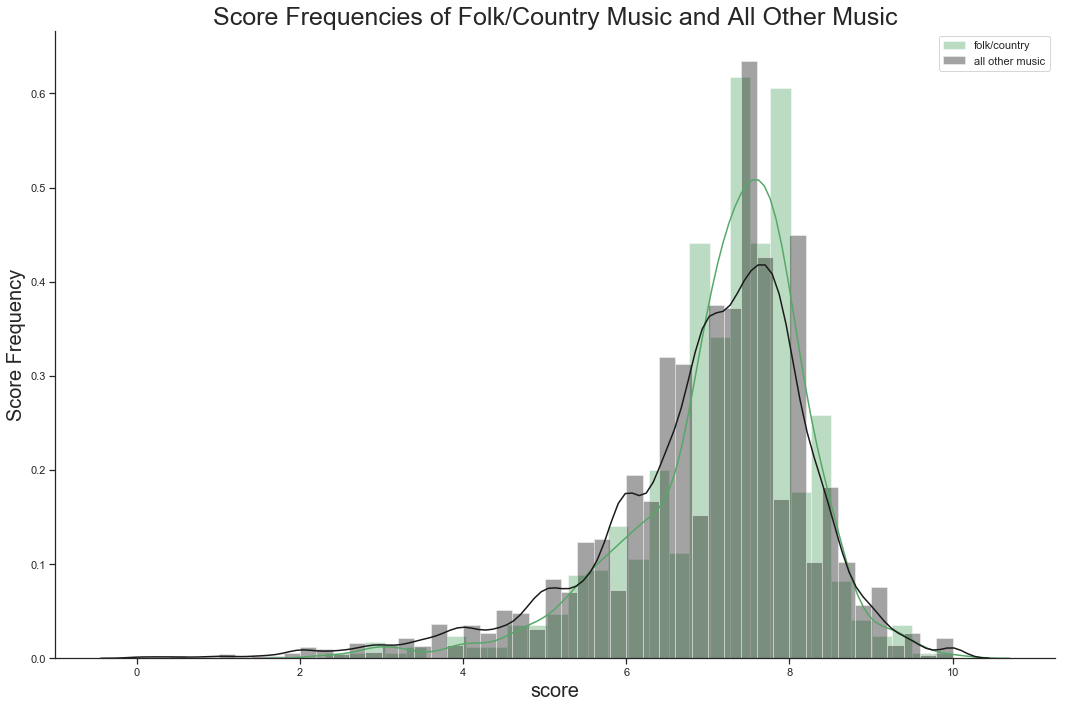

In [111]:
sns.set()
plt.figure(figsize=(15,10))
sns.set_style("white", {"xtick.bottom":True, "ytick.left":True})
plt.xlabel('Score', fontsize='20')
plt.ylabel('Score Frequency', fontsize='20')
plt.title('Score Frequencies of Folk/Country Music and All Other Music', fontsize='25')
sns.distplot(fc_df['score'], color='g', label='folk/country')
sns.distplot(og_df['score'], color='k', label='all other music')
sns.despine()
plt.tight_layout()
plt.legend()
plt.show();

From a visual, it looks like there is little, if any, difference between folk/country ratings and all other music. To determine whether folk/country ratings or all other music ratings we use a Welch's T-Test to compare the average ratings for each sample. We also conduct a power analysis. By convention, significance level (alpha) is 0.05, effect size (Cohen's d measure) is at least 0.8, and statistical power is 0.8. Our hypotheses are: <br>
Null Hypothesis: The mean difference between review score for folk/country and all other music is zero. <br>
Alternative Hypothesis: The mean difference between review score folk/country and all other music is different from zero. <br>

In [174]:
# Use scipy.stats to conduct 2-sample t-test
ttest_ind(fc_df['score'], og_df['score'], equal_var=False )

Ttest_indResult(statistic=5.228327988171828, pvalue=2.2201136243634723e-07)

The p-value is ~ 2.22, which is greater than 0.05. Not enough evidence to reject null hypothesis. There is no statistical difference in the average review scores between folk/country and all other music. <br> <br>
Next, do a power analysis to estimate a suitable sample size (how many observations needed for each sample) to detect an effect of 0.8 with an 80% chance of detecting the effect if it is true (so 20% false negatives) and a 5% chance of detecting an effect if there is no effect (false positives). 

In [175]:
# Initialize parameters
effect = 0.8
alpha = 0.05
power = 0.8
# Size of folk/country scores sample to all other music sample
ratio = len(fc_df) / len(og_df)  
# Perform power analysis
analysis = TTestIndPower()
result = analysis.solve_power(effect, power=power, nobs1=None,
                             ratio=ratio, alpha=alpha)
print(f"Minimum Sample Size: {result}")
print(f"Folk/Country Sample Size:{len(fc_df)}")

Minimum Sample Size: 408.09978349002654
Folk/Country Sample Size:685


The sample size of folk country is greater than the estimated sample size needed. Generate power curves, to visualize how effect changes with different sample sizes.

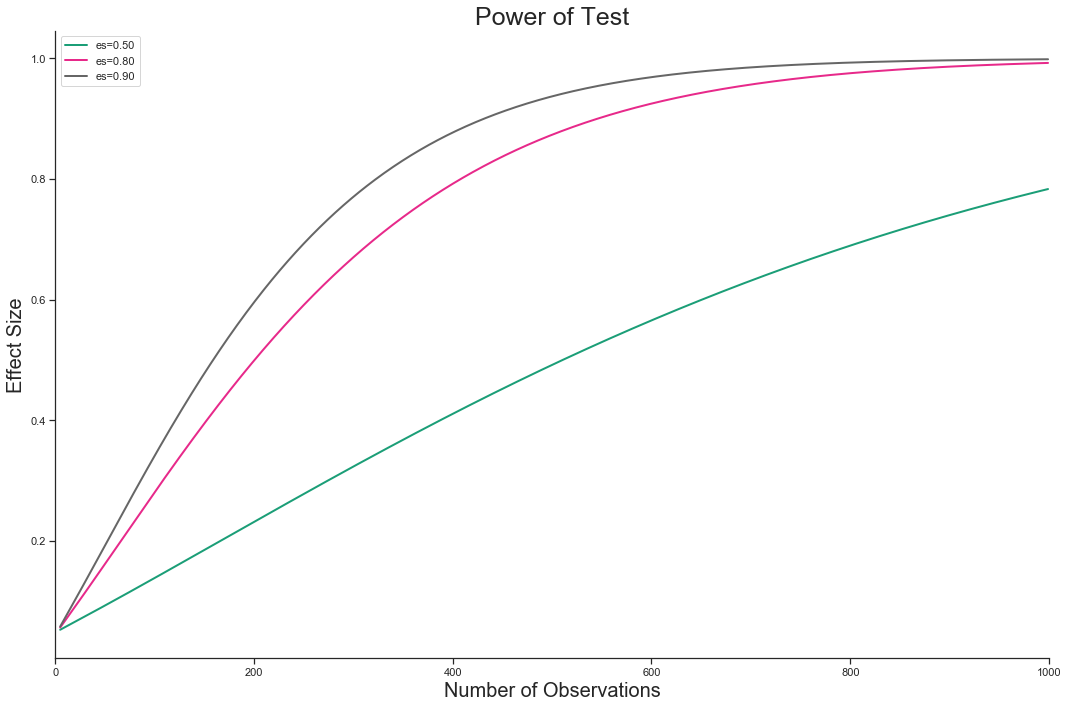

In [176]:
# parameters for power analysis
effect_sizes = np.array([0.5, 0.8, 0.9])
sample_sizes = np.array(range(5, 1000))
# Calculate multiple power analysis curves
analysis = TTestIndPower()
sns.set()
sns.set_style("white", {"xtick.bottom":True, "ytick.left":True})
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1)
ax = analysis.plot_power(dep_var='nobs', nobs=sample_sizes, ax=ax, ratio=ratio, effect_size=effect_sizes)
plt.xlabel('Number of Observations', fontsize='20')
plt.xlim(0, 1000)
plt.ylabel('Effect Size', fontsize='20')
plt.title('Power of Test', fontsize='25')
sns.despine()
plt.tight_layout()
plt.legend()
plt.show();

The number of observations plateaus around 700 for an 90% chance of detecting an effect close to 1.